## Introduction

Customer churn, when clients stop using a company’s services, is one of the most pressing challenges in the banking industry. Retaining existing customers is often far more cost-effective than acquiring new ones, and high churn rates can directly impact a bank’s profitability, customer lifetime value, and overall stability.

In this project, we aim to predict customer churn using a publicly available bank dataset. The main objective is to identify which customers are most likely to leave so that proactive retention strategies can be designed. Specifically, we want to reduce false negatives (missing at-risk customers) while maintaining a reasonable precision so that resources are not wasted on customers unlikely to churn.

## Methodology

Our approach involved several key steps:

Exploratory Data Analysis (EDA): Understanding patterns and drivers of churn, such as geography, age, balance, tenure, and customer activity.

Data Preprocessing: Handling categorical variables through encoding, scaling numerical features, and addressing class imbalance with techniques like class weights and SMOTE.

Feature Engineering: Examining feature importance and interactions to strengthen predictive power.

Modeling: Training a simple and a complex model, Logistic Regression, and XGBoost, with a focus on recall for churned customers.

Evaluation: Comparing models based on recall, precision, F1-score, and business relevance to identify the most effective solution

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action = "ignore")

In [3]:
#Load the data
df= pd.read_csv(r"C:\Users\pc\Desktop\IT Project\Churn_Modelling.csv")

# DATA EXPLORATION AND CLEANING

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
#Find out the data type of the features, check if there are null values,find out how may rows and how many columns are there.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
#Check for duplicate values
duplicates = df[df.duplicated()]

print(duplicates)

Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []


In [7]:
#Get the summary statistics
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
df.columns


Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [9]:
#drop unnessary columns
df= df.drop(['RowNumber','CustomerId','Surname'], axis = 1)

# FURTHER EXPLORATORY DATA ANALYSIS 

In [10]:
#Checking the churn rate
Churn_rate = df['Exited'].value_counts(normalize=True)*100  # Churn rate
Churn_rate

Exited
0    79.63
1    20.37
Name: proportion, dtype: float64

20% of the customers churned. The dataset is imbalanced.

Text(0, 0.5, '')

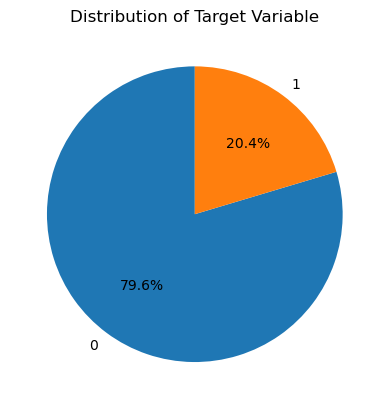

In [11]:
#Visualizing the churn rate
Churn_rate.plot(kind='pie', autopct='%1.1f%%', startangle = 90)
plt.title('Distribution of Target Variable')
plt.ylabel('')

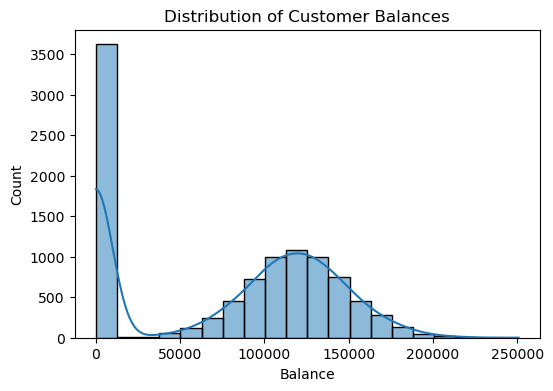

In [12]:
#Visualizing the distribution of customer balances
plt.figure(figsize=(6,4))
sns.histplot(df['Balance'], bins=20, kde=True)
plt.title("Distribution of Customer Balances")
plt.xlabel("Balance")
plt.show()

From the plot, we see that approximately 3500 customers have a balance between 0 and a small positive number
The graph shows a bimodal distribution, meaning it has two distinct peaks.  
The first, very tall peak near 0 suggests a large number of customers with very low or zero balances. 
The second, more moderate peak around $125,000 indicates another group of customers with a higher concentration of balances around that amount.

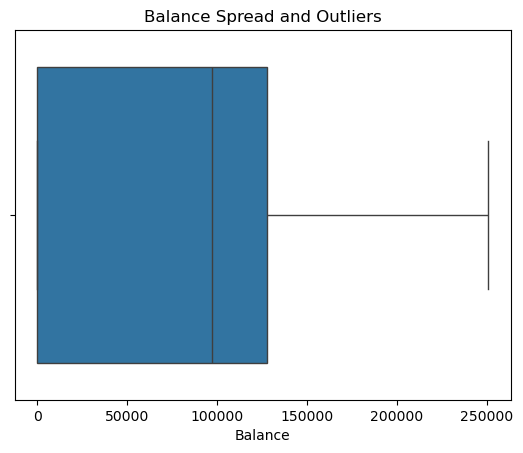

In [13]:
sns.boxplot(x=df['Balance'])
plt.title("Balance Spread and Outliers")
plt.show()

The plot shows that the median balance is around $100,000, with half of the customers having a balance less 
than this amount and the other half having a balance greater than it. The interquartile range (IQR), represented by the box, 
contains the middle 50% of customer balances. There are no dots or symbols outside the "whiskers" of the plot therefore,
there are no outliers in the dataset. This means that all customer balances fall within a relatively predictable range, 
without any extremely high or low values.

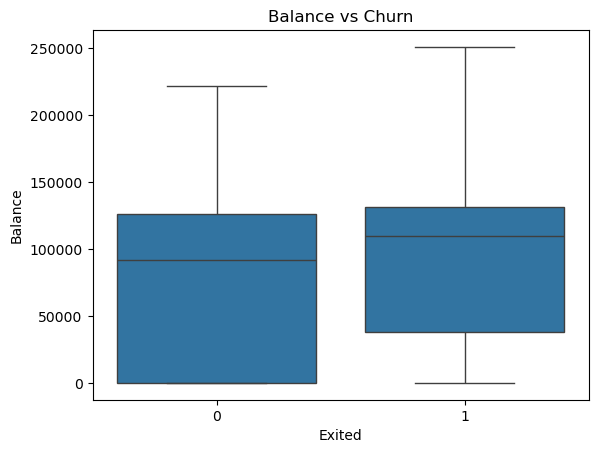

In [14]:
#Checking how churn affects balance
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title("Balance vs Churn")
plt.show()

The plot above shows that the median balance (indicated by the black line in the box) of customers who churned is slightly higher 
than balance of customers who did not churn. This contradicts the assumption that customers with lower balances are more 
likely to churn and suggests that other factors may be responsible for churn. So let's explore further.

#####**Exploring credit score.***
A credit score is a three-digit number that represents an individual's or business's creditworthiness 
and is used by lenders to determine the likelihood of repaying debts on time.
We need to check if the distribution is skewed toward good/bad credit and
if customers with low credit scores churn more.

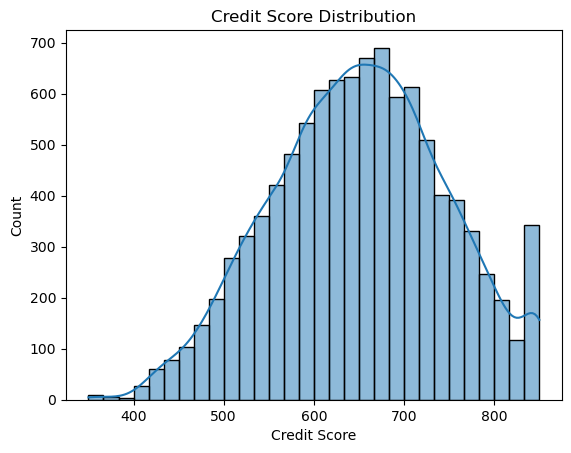

In [15]:
#Checking the distribution of credit score
sns.histplot(df['CreditScore'], bins=30, kde=True)
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.show()

The majority of customers have a credit score between 550 and 750, with the highest concentration occurring around 670.
There is a smaller bump in the distribution around 800-850, which suggests a small number of customers have very high credit scores.

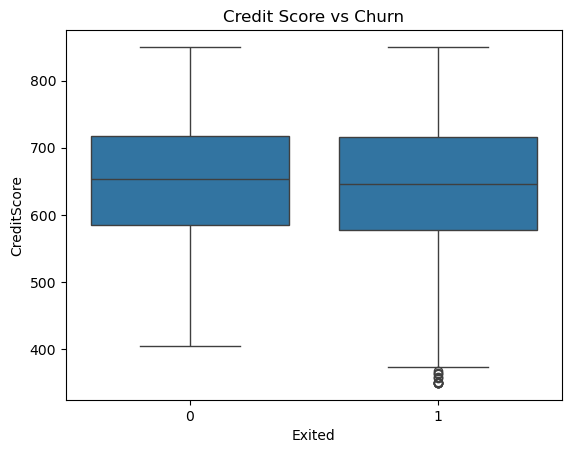

In [16]:
#Checking how creditscore affects churn
sns.boxplot(x='Exited', y='CreditScore', data=df)
plt.title("Credit Score vs Churn")
plt.show()

The median scores are similar, but there are several outliers in the churned group, with credit scires less than 400. 
This suggest that while most churned customers have a similar credit score to those who stay, 
customers with very poor credit are at a higher risk of churning.

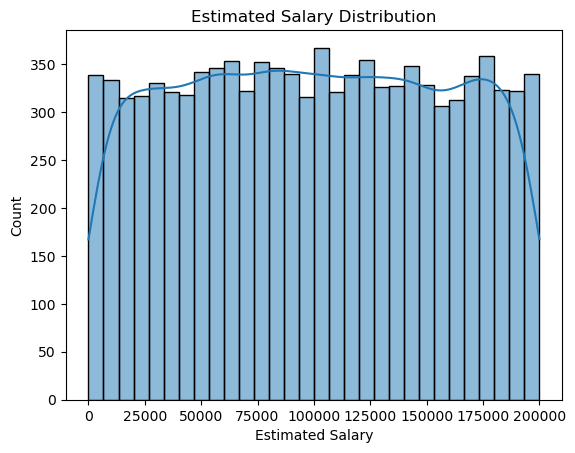

In [17]:
#Checking the distribution of the estimated Salary
sns.histplot(df['EstimatedSalary'], bins=30, kde=True)
plt.title("Estimated Salary Distribution")
plt.xlabel("Estimated Salary")
plt.show()

The plot indicates that the number of customers is roughly the same across all salary brackets, 
from the lowest to the highest estimated salary. There is no major concentration of customers at any specific salary level.

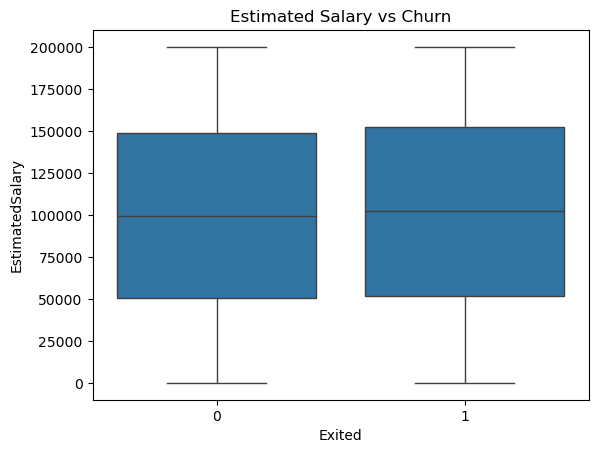

In [18]:
#Checking if Estimated Salary afffects churn
sns.boxplot(x='Exited', y='EstimatedSalary', data=df)
plt.title("Estimated Salary vs Churn")
plt.show()

The plot shows that there is no significant difference in estimated salary between customers who churn and those who do not.
The median estimated salary (the horizontal line inside the box) is almost identical for both groups, sitting at around $100,000.

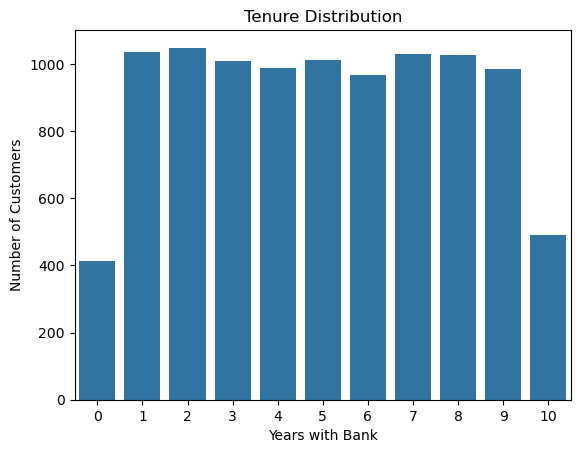

In [19]:
#Exploring tenure lengths
sns.countplot(x='Tenure', data=df)
plt.title("Tenure Distribution")
plt.xlabel("Years with Bank")
plt.ylabel("Number of Customers")
plt.show()

The distribution is largely uniform for tenures between 1 and 9 years, with approximately 1000 
customers in each of those categories. This indicates that the bank has had a consistent number of 
customers for most of its recent history.
The number of customers with 0 years of tenure (brand new customers) is very low, at around 400.
The number of customers with 10 years of tenure is also significantly lower than the middle years, at around 500.
This suggests that the bank may be struggling to acquire a high volume of new customers and may also experience a 
higher churn rate after customers reach a 10-year milestone.

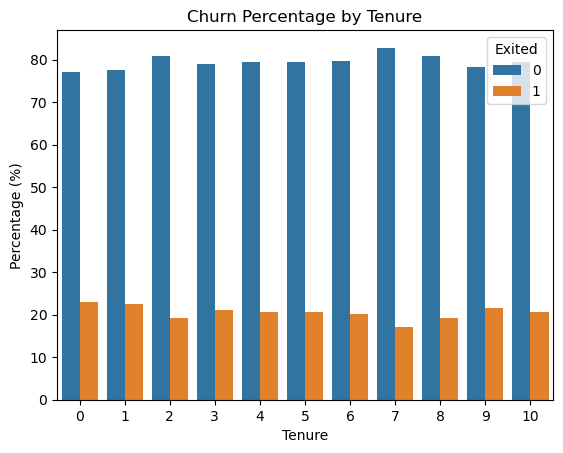

In [20]:
#Churn percentage by tenure
tenure_churn = (
    df.groupby('Tenure')['Exited']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
)
sns.barplot(x='Tenure', y='percentage', hue='Exited', data=tenure_churn)
plt.title("Churn Percentage by Tenure")
plt.ylabel("Percentage (%)")
plt.show()

#####**No Clear Trend:**
The plot shows that there is no clear relationship between a customer's 
tenure and their likelihood of churning. The percentage of customers who exited is 
consistently between 20% and 25% for nearly all years.

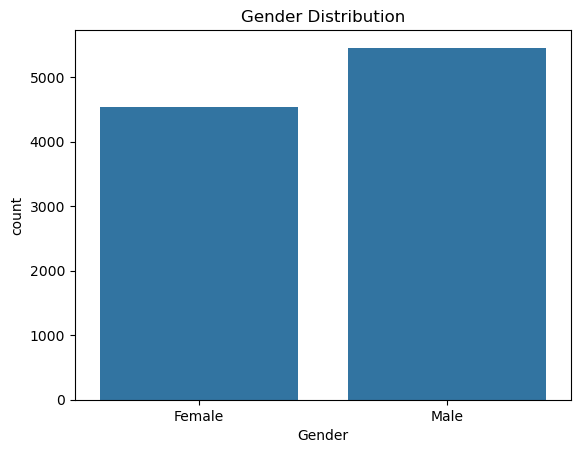

In [21]:
#Distribution of Gender
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")
plt.show()

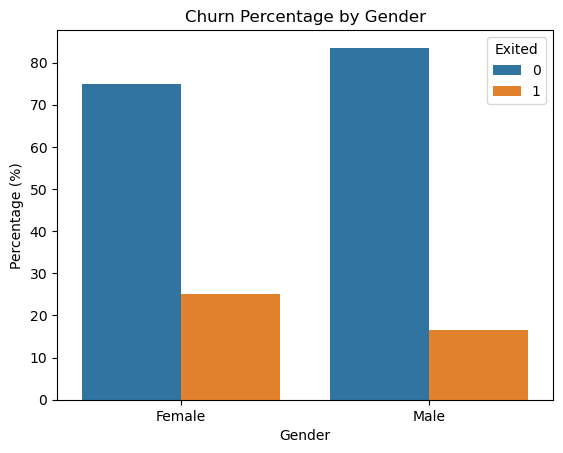

In [22]:
#Churn percentage by gender
gender_churn = (
    df.groupby('Gender')['Exited']
      .value_counts(normalize=True)
      .rename('percentage')
      .mul(100)
      .reset_index()
)
sns.barplot(x='Gender', y='percentage', hue='Exited', data=gender_churn)
plt.title("Churn Percentage by Gender")
plt.ylabel("Percentage (%)")
plt.show()

The plot shows that a higher percentage of female customers have exited the bank compared to male customers. 
This indicates a strong relationship between gender and customer churn.

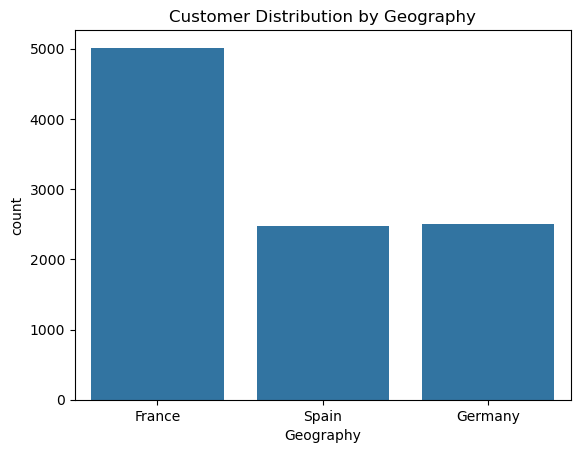

In [23]:
#Find out which countries have more customers
sns.countplot(x='Geography', data=df)
plt.title("Customer Distribution by Geography")
plt.show()

The plot shows that France has the largest number of customers, with a count of approximately 5,000.

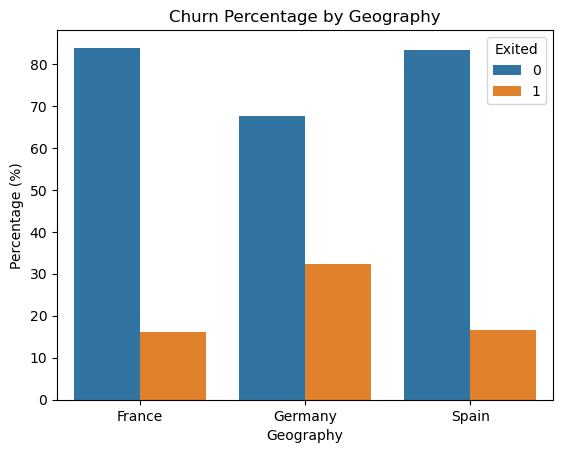

In [24]:
#Exploring churn rate by geography
geo_churn = (
    df.groupby('Geography')['Exited']
      .value_counts(normalize=True)
      .rename('percentage')
      .mul(100)
      .reset_index()
)
sns.barplot(x='Geography', y='percentage', hue='Exited', data=geo_churn)
plt.title("Churn Percentage by Geography")
plt.ylabel("Percentage (%)")
plt.show()

According to this plot, geography is a strong predictor of churn, 
and customers in Germany are considerably more likely to leave the bank than customers in France or Spain.

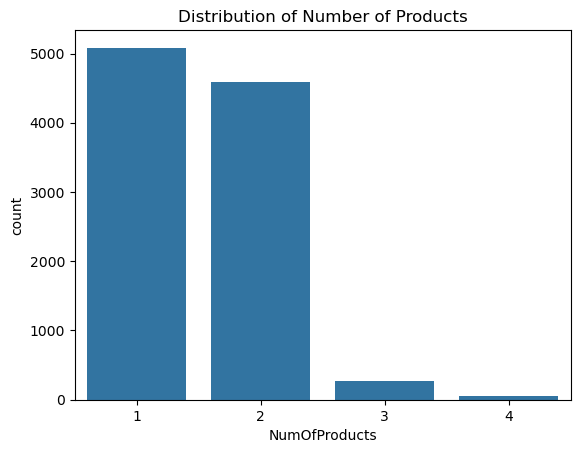

In [25]:
#How many products do customer's typically have?
sns.countplot(x='NumOfProducts', data=df)
plt.title("Distribution of Number of Products")
plt.show()

The chart reveals that the vast majority of the bank's customers have either 1 or 2 products.

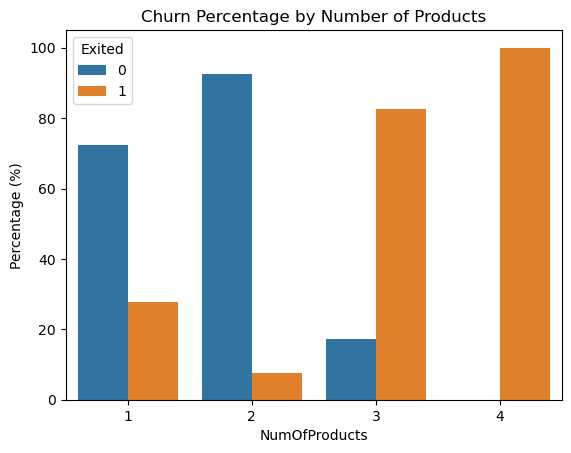

In [26]:
#%Churn by number of products
prod_churn = (
    df.groupby('NumOfProducts')['Exited']
      .value_counts(normalize=True)
      .rename('percentage')
      .mul(100)
      .reset_index()
)
sns.barplot(x='NumOfProducts', y='percentage', hue='Exited', data=prod_churn)
plt.title("Churn Percentage by Number of Products")
plt.ylabel("Percentage (%)")
plt.show()

Customers with 2 products have the lowest churn rate, at under 10%. Customers with 1 product also have a relatively low churn rate, around 25-30%.
Customers with 3 or 4 products have an exceptionally high churn rate, approaching 100%.
The chart indicates that the number of products a customer holds is a major predictor of churn.

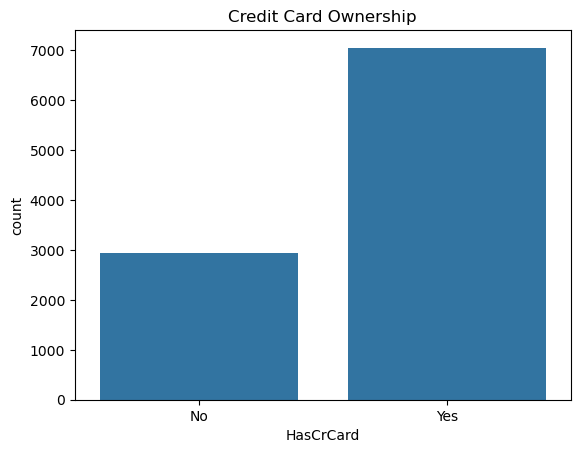

In [27]:
#Going further to check how many percentage of the customers own a credit card and if credit card ownership affects churn
sns.countplot(x='HasCrCard', data=df)
plt.title("Credit Card Ownership")
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

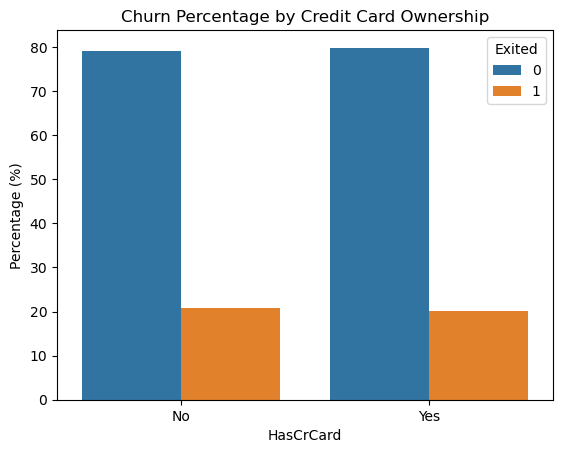

In [28]:
card_churn = (
    df.groupby('HasCrCard')['Exited']
      .value_counts(normalize=True)
      .rename('percentage')
      .mul(100)
      .reset_index()
)
sns.barplot(x='HasCrCard', y='percentage', hue='Exited', data=card_churn)
plt.title("Churn Percentage by Credit Card Ownership")
plt.ylabel("Percentage (%)")
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

This plot indicates that a customer's credit card ownership status has no significant impact on their likelihood of churning.

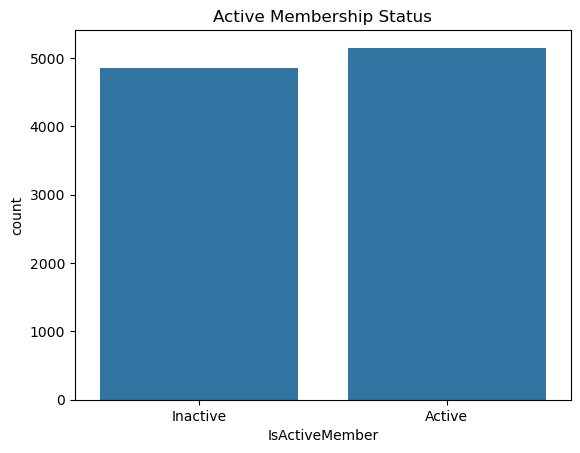

In [29]:
#Investigating what proportion of customers are active members
sns.countplot(x='IsActiveMember', data=df)
plt.title("Active Membership Status")
plt.xticks([0,1], ['Inactive', 'Active'])
plt.show()

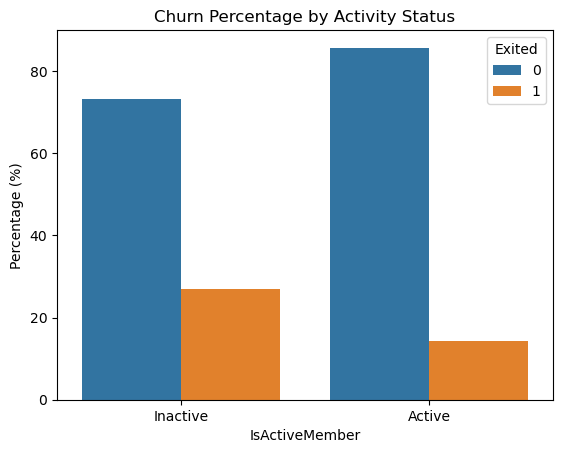

In [30]:
#Does activity status affect churn?
active_churn = (
    df.groupby('IsActiveMember')['Exited']
      .value_counts(normalize=True)
      .rename('percentage')
      .mul(100)
      .reset_index()
)
sns.barplot(x='IsActiveMember', y='percentage', hue='Exited', data=active_churn)
plt.title("Churn Percentage by Activity Status")
plt.ylabel("Percentage (%)")
plt.xticks([0,1], ['Inactive', 'Active'])
plt.show()

Inactive customers have a significantly higher churn rate (around 25-28%) than active customers.
The churn rate for active members is noticeably lower, at around 15-18%.

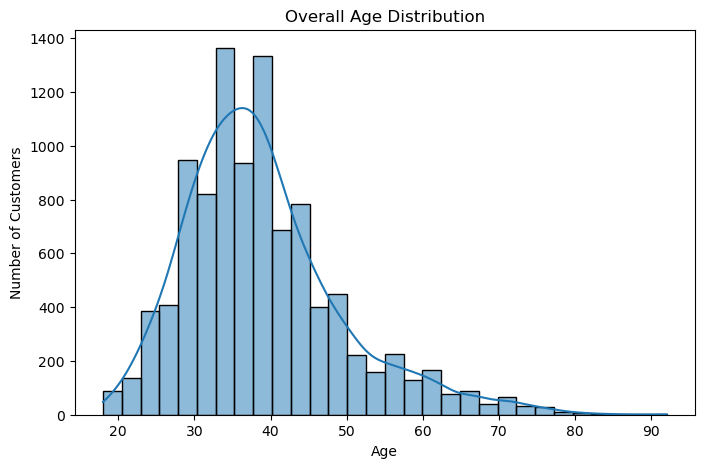

In [31]:
#Exploring the age column
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='Age', kde=True, bins=30)
plt.title("Overall Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.show()

Majority of the customer's are between ages 30-40

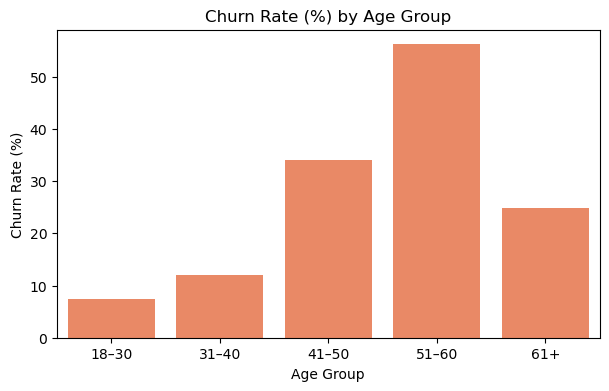

In [32]:
#Age vs churn
# Create Age Groups (covering full 18–92 range)
df['AgeGroup'] = pd.cut(
    df['Age'],
    bins=[18, 30, 40, 50, 60, 92],                
    labels=['18–30', '31–40', '41–50', '51–60', '61+']
)

# Calculate churn rate (%) per Age Group
churn_by_age = df.groupby('AgeGroup')['Exited'].mean() * 100

# Plot churn rate by Age Group
plt.figure(figsize=(7, 4))
sns.barplot(x=churn_by_age.index, y=churn_by_age.values, color="coral")
plt.title('Churn Rate (%) by Age Group')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Age Group')
plt.show()

The churn rate is relatively low for younger customers, staying below 15% for the 18-30 and 31-40 age groups.
It then rises sharply for the 41-50 age group, with a churn rate over 30%.
The churn rate peaks dramatically at over 55% for the 51-60 age group.
The churn rate for customers aged 61+ drops slightly from the peak, it remains very high, at over 25%.
Older customers are at a much higher risk of churning. 

# DATA PREPROCESSING

In [33]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,41–50
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,41–50
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,41–50
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,31–40
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,41–50


In [34]:
#Perform category encoding on the Geography and Gender Columns.
'''df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df = pd.get_dummies(df, columns=['Geography'] )'''
df = pd.get_dummies(
        df, 
        columns=[col for col in df.columns if df[col].dtype == 'object'],  drop_first = True
     )

In [35]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,41–50,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,41–50,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,41–50,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,31–40,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,41–50,False,True,False


# FEATURE ENGINEERING


Our EDA showed that customers with 3 or 4 products have a near 100% churn rate. Asssuming it may be that the customer probably has their
money spread across several accounts. We'll be creating a new feature called balanceperproduct to test this hypothesis.


In [36]:
# Create the new feature by dividing Balance by NumOfProducts
df['BalancePerProduct'] = np.where(df['NumOfProducts'] != 0,
                                   df['Balance'] / df['NumOfProducts'],
                                   0)

In [37]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,Geography_Germany,Geography_Spain,Gender_Male,BalancePerProduct
0,619,42,2,0.00,1,1,1,101348.88,1,41–50,False,False,False,0.000000
1,608,41,1,83807.86,1,0,1,112542.58,0,41–50,False,True,False,83807.860000
2,502,42,8,159660.80,3,1,0,113931.57,1,41–50,False,False,False,53220.266667
3,699,39,1,0.00,2,0,0,93826.63,0,31–40,False,False,False,0.000000
4,850,43,2,125510.82,1,1,1,79084.10,0,41–50,False,True,False,125510.820000


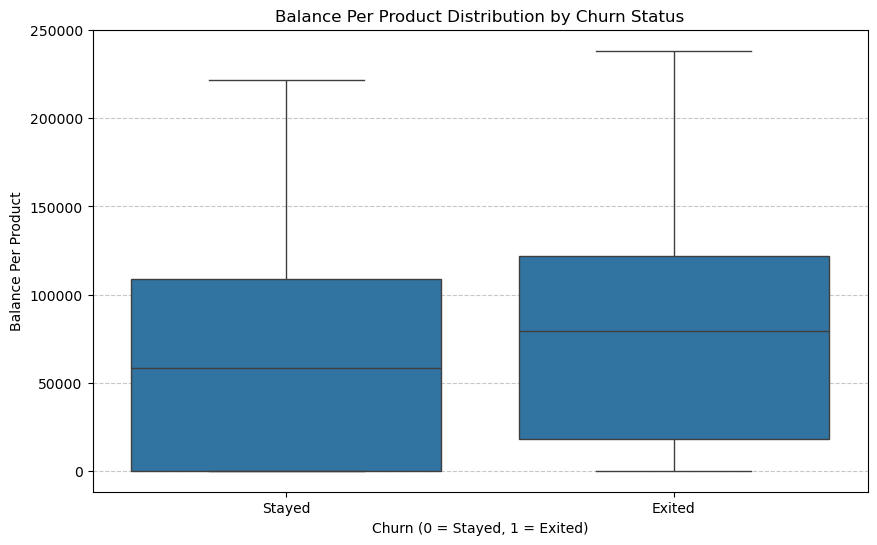

In [38]:
#Plotting to see how balanceperproduct affects churn

plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='BalancePerProduct', data=df)
plt.title('Balance Per Product Distribution by Churn Status')
plt.xlabel('Churn (0 = Stayed, 1 = Exited)')
plt.ylabel('Balance Per Product')
plt.xticks([0, 1], ['Stayed', 'Exited'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The median BalancePerProduct for churned customers is higher than for customers who stayed.


In [39]:
df.dtypes

CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
AgeGroup             category
Geography_Germany        bool
Geography_Spain          bool
Gender_Male              bool
BalancePerProduct     float64
dtype: object

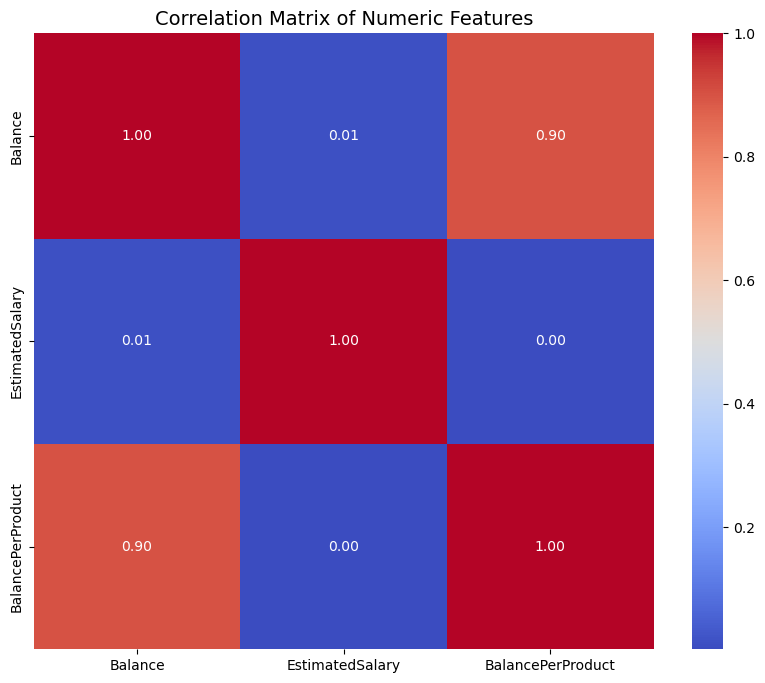

In [40]:
#Plotting a correlation matrix to be sure we don't have redundant features e.g balance and balance per product
num_cols = df.select_dtypes(include=['int32', 'float64']).columns
# Compute the correlation matrix
corr_matrix = df[num_cols].corr()

# Visualize as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.show()

There is clearly a strong correlation between balance per product and balance so we will be dropping balanceperproduct

In [41]:
df = df.drop(['BalancePerProduct', 'AgeGroup'], axis = 1)


In [42]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [43]:
#Scale the dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

#  CreditScore and Age have distributions suited for StandardScaler. The distribution is close to normal
#  Balance, Tenure, and EstimatedSalary are better suited for MinMaxScaler. The distribution is clearly not a normal distribution
cols_standard = ['CreditScore', 'Age']
cols_minmax = ['Balance', 'Tenure', 'EstimatedSalary']

df[cols_standard] = scaler_standard.fit_transform(df[cols_standard])
df[cols_minmax] = scaler_minmax.fit_transform(df[cols_minmax])

print("DataFrame after scaling:")
df.head()

DataFrame after scaling:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,0.2,0.000000,1,1,1,0.506735,1,False,False,False
1,-0.440036,0.198164,0.1,0.334031,1,0,1,0.562709,0,False,True,False
2,-1.536794,0.293517,0.8,0.636357,3,1,0,0.569654,1,False,False,False
3,0.501521,0.007457,0.1,0.000000,2,0,0,0.469120,0,False,False,False
4,2.063884,0.388871,0.2,0.500246,1,1,1,0.395400,0,False,True,False


In [44]:
#Setting X and Y values
X = df.drop('Exited', axis=1)
y = df['Exited']

In [45]:
#imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter


In [46]:
# Train/Val/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=2/3, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (7000, 11) (7000,)
Validation: (1000, 11) (1000,)
Test: (2000, 11) (2000,)


In [47]:
#Apply SMOTE on the Training data set
print("Before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_res))

Before SMOTE: Counter({0: 5574, 1: 1426})
After SMOTE: Counter({0: 5574, 1: 5574})


In [48]:
#  Baseline Logistic Regression using classweights because it works better for logistic regression.
log_reg = LogisticRegression(random_state=42, class_weight = 'balanced', max_iter=1000)
log_reg.fit(X_train, y_train)

y_val_pred_lr = log_reg.predict(X_val)
print("\nLogistic Regression (Validation):")
print(classification_report(y_val, y_val_pred_lr))


Logistic Regression (Validation):
              precision    recall  f1-score   support

           0       0.91      0.72      0.81       796
           1       0.40      0.72      0.51       204

    accuracy                           0.72      1000
   macro avg       0.66      0.72      0.66      1000
weighted avg       0.81      0.72      0.75      1000



In [49]:
#  Baseline XGBoost (no tuning)
baseline_xgb = XGBClassifier(
    objective="binary:logistic",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

baseline_xgb.fit(X_train_res, y_train_res)

y_val_pred_base = baseline_xgb.predict(X_val)
y_val_proba_base = baseline_xgb.predict_proba(X_val)[:, 1]

precision_base = precision_score(y_val, y_val_pred_base)
recall_base = recall_score(y_val, y_val_pred_base)
f1_base = f1_score(y_val, y_val_pred_base)
roc_auc_base = roc_auc_score(y_val, y_val_proba_base)
pr_auc_base = average_precision_score(y_val, y_val_proba_base)

print("\nBaseline XGBoost (Validation, with SMOTE)")
print(f"Precision: {precision_base:.4f}")
print(f"Recall:    {recall_base:.4f}")
print(f"F1:        {f1_base:.4f}")
print(f"ROC AUC:   {roc_auc_base:.4f}")
print(f"PR AUC:    {pr_auc_base:.4f}")
print("\nConfusion Matrix (Baseline XGB):")
print(confusion_matrix(y_val, y_val_pred_base))


Baseline XGBoost (Validation, with SMOTE)
Precision: 0.6237
Recall:    0.5931
F1:        0.6080
ROC AUC:   0.8767
PR AUC:    0.6924

Confusion Matrix (Baseline XGB):
[[723  73]
 [ 83 121]]


In [50]:
#  Hyperparameter Tuning (optimize F1 instead of Recall)
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)

param_dist = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,                 # more depth for better search
    scoring='f1',              # balance precision & recall
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_res, y_train_res)
best_model = search.best_estimator_

print("\nBest Params:", search.best_params_)
print("Best F1 Score (CV):", search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best Params: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best F1 Score (CV): 0.8425247729821385


In [51]:
#  Tuned XGBoost Validation Performance
y_val_pred_tuned = best_model.predict(X_val)
y_val_proba_tuned = best_model.predict_proba(X_val)[:, 1]

print("\nTuned XGBoost (Validation, with SMOTE):")
print(classification_report(y_val, y_val_pred_tuned))



Tuned XGBoost (Validation, with SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       796
           1       0.67      0.51      0.58       204

    accuracy                           0.85      1000
   macro avg       0.78      0.72      0.74      1000
weighted avg       0.84      0.85      0.84      1000



In [52]:
#  Before vs After Comparison Table
comparison = pd.DataFrame([
    {"Model": "Baseline XGB", "Precision": precision_base, "Recall": recall_base, "F1": f1_base, "ROC AUC": roc_auc_base, "PR AUC": pr_auc_base},
    {"Model": "Tuned XGB", 
     "Precision": precision_score(y_val, y_val_pred_tuned),
     "Recall": recall_score(y_val, y_val_pred_tuned),
     "F1": f1_score(y_val, y_val_pred_tuned),
     "ROC AUC": roc_auc_score(y_val, y_val_proba_tuned),
     "PR AUC": average_precision_score(y_val, y_val_proba_tuned)}
])

print("\nComparison of Models (Validation Performance):")
print(comparison.round(4))


Comparison of Models (Validation Performance):
          Model  Precision  Recall      F1  ROC AUC  PR AUC
0  Baseline XGB     0.6237  0.5931  0.6080   0.8767  0.6924
1     Tuned XGB     0.6688  0.5147  0.5817   0.8638  0.6774


In [53]:
# Probabilities of being churn (class=1)
y_val_proba_tuned = best_model.predict_proba(X_val)[:, 1]


In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Try thresholds between 0.1 and 0.9
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_val_proba_tuned >= thresh).astype(int)
    precision = precision_score(y_val, y_pred_thresh)
    recall = recall_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)
    results.append([thresh, precision, recall, f1])

results_df = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1"])
print(results_df)


    Threshold  Precision    Recall        F1
0        0.10   0.322034  0.931373  0.478589
1        0.15   0.376543  0.897059  0.530435
2        0.20   0.423645  0.843137  0.563934
3        0.25   0.481159  0.813725  0.604736
4        0.30   0.525597  0.754902  0.619718
5        0.35   0.545817  0.671569  0.602198
6        0.40   0.580645  0.617647  0.598575
7        0.45   0.614130  0.553922  0.582474
8        0.50   0.668790  0.514706  0.581717
9        0.55   0.695652  0.470588  0.561404
10       0.60   0.723577  0.436275  0.544343
11       0.65   0.761468  0.406863  0.530351
12       0.70   0.797872  0.367647  0.503356
13       0.75   0.853333  0.313725  0.458781
14       0.80   0.878788  0.284314  0.429630
15       0.85   0.870370  0.230392  0.364341


# Model Comparison (Validation Results)

Logistic Regression (with class weights): Recall (churn) = 0.72, Precision = 0.40 → Strong at capturing most churners, but more false positives.

Tuned XGBoost (with SMOTE): Recall (churn) = 0.51, Precision = 0.67 → Fewer false positives, but misses more churners.

Threshold tuning (XGBoost): Showed clear trade-off — higher recall lowers precision, and vice versa.

Decision: We prioritize recall (catching churners) over precision since losing a churner is costlier than incorrectly flagging a non-churner. Logistic Regression is chosen as the primary model.

In [55]:
# Evaluate Logistic Regression on Test Set
y_test_pred_lr = log_reg.predict(X_test)

print("\nLogistic Regression (Test Results):")
print(classification_report(y_test, y_test_pred_lr))



Logistic Regression (Test Results):
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1593
           1       0.39      0.73      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.81      0.72      0.74      2000



In [60]:
# If you already encoded/scaled X_train before fitting:
feature_names = X_train.columns  # feature names after preprocessing

# Extract coefficients from logistic regression
coef = log_reg.coef_[0]

# Put into DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef,
    "Importance": np.abs(coef)  # absolute effect size
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(10))


              Feature  Coefficient  Importance
6      IsActiveMember    -0.876969    0.876969
8   Geography_Germany     0.812742    0.812742
1                 Age     0.755048    0.755048
3             Balance     0.642537    0.642537
10        Gender_Male    -0.531720    0.531720
7     EstimatedSalary     0.171218    0.171218
0         CreditScore    -0.103451    0.103451
4       NumOfProducts    -0.048760    0.048760
9     Geography_Spain     0.036835    0.036835
5           HasCrCard    -0.028517    0.028517


## Model Feature Importance (Top Drivers of Churn)

From the logistic regression coefficients:

IsActiveMember (-0.88) → Being an active member greatly reduces churn. Inactive customers are much more likely to leave.

Geography_Germany (+0.81) → Customers in Germany are at far higher risk of churning compared to other regions.

Age (+0.76) → Older customers (especially 40+) are more likely to churn.

Balance (+0.64) → Customers with higher balances show higher churn risk.

Gender_Male (-0.53) → Female customers are more likely to churn than males.

Other features like salary, credit score, and number of products had weaker influence.

## Business Insights for the Bank

Re-engage inactive customers: Since inactivity is the top churn driver, targeted campaigns (loyalty rewards, check-ins, or activity-based benefits) could reduce churn quickly.

Focus on Germany: Customers in Germany are systematically higher-risk. The bank may need localized retention strategies (e.g., better customer service, competitive offers).

Design retention programs for older customers: Churn risk rises sharply after age 40. Tailored financial products (retirement plans, investment services) may keep them engaged.

 Pay attention to high-balance customers: Counterintuitively, they are churning more. This suggests dissatisfaction despite wealth — perhaps they expect premium service or competitive returns.

 Address female customer churn: Since women churn more, explore if customer service, product offerings, or communication strategies are unintentionally skewed.